In [1]:

import matplotlib.pyplot as plt
import pandas as pd
import sqlalchemy

import numpy as np
import pandas as pd
import datetime as dt

import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

from scalecast.Forecaster import Forecaster
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.dates as mdates


In [6]:
#engine = create_engine("sqlite:///RestaurantDB.sqlite")
engine = create_engine("sqlite:///RestaurantDB.sqlite")

Base = automap_base()
Base.prepare(engine, reflect=True)

In [9]:
Base.classes.keys()


[]

In [10]:
Sales = Base.classes.sales


AttributeError: sales

In [6]:
session = Session(engine)

In [7]:
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('sales')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
item VARCHAR(255)
price INTEGER
sold INTEGER
tot_value FLOAT
month INTEGER
year INTEGER
date VARCHAR(255)


In [20]:
def py_bar(item_df,item):
    item_df = item_df.set_index('date')
    line_plot = item_df.sold

    fig, ax = plt.subplots(figsize=(10,10))
    bar_plot = line_plot.groupby([line_plot.index.year, line_plot.index.month]).mean().unstack()
    bar_plot.plot(ax = ax, kind='bar', width=1)
    ax.set_xlabel('Years')
    ax.set_ylabel('Items Sold (Montly)')
    
    handles, labels = ax.get_legend_handles_labels()
    new_labels = [dt.date(1900, int(monthinteger), 1).strftime('%B') for monthinteger in labels]
    ax.legend(handles = handles, labels = new_labels, loc = 'upper left', bbox_to_anchor = (1.02, 1))
    plt.title(item)
    savefile = item + "_bar" + ".png"
    plt.savefig(savefile)
    plt.show()
    

In [9]:
def sea_scatter(item_df,item):
    fig_size = (12,8)
    fig, ax = plt.subplots(figsize=fig_size)
    g=sns.scatterplot(ax=ax,data=item_df,
                    x="date", 
                    y="sold",
                    markers=True,
                    style='Month', 
                    hue="Month", 
                    size='sold', 
                    legend='full', 
                    palette="muted")
    g.set_ylabel('Total Sold',fontsize=16)
    g.set_xlabel('Date',fontsize=16)
    h,l = g.get_legend_handles_labels()
    plt.legend(h[0:13],l[0:13],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=13)
    plt.title(item,fontsize=20)

    savefile = item + "_scatter" + ".png"
    plt.savefig(savefile)
    
    
    

In [10]:
def scatter_graph(test_df, title):
    x = test_df['date']
    y = test_df['sold']
    
    plt.scatter(x,y)
    
    plt.title(title,fontsize=25)
    plt.legend(['quantity'], loc='upper center')
    plt.xlabel('year', fontsize=20)
    plt.ylabel('qty sold', fontsize=20)
    
    plt.show()

In [11]:
def sql_meat_item(type):
    query = [Meat.date, Meat.price, Meat.percentage_change]
   
    item_query = session.query(*query).\
    filter_by(type=type).all()
   
    item_df = pd.DataFrame(item_query, columns=['date', 'price', 'percentage_change'])
   
    item_df['date'] = pd.to_datetime(item_df['date'], format="%b-%y", errors = 'coerce') 
    item_df = item_df.sort_values(by=['date'])
    
    return item_df

In [12]:
def sql_total():
    query = [Sales.item, Sales.sold, Sales.date, Sales.tot_value]
    
    item_query = session.query(*query).all()

    item_df = pd.DataFrame(item_query, columns=['item', 'sold', 'date', 'total($)'])
    
    item_df['date'] = pd.to_datetime(item_df['date'], format='%Y/%m/%d')
    item_df = item_df.sort_values(by=['date'])
    
    return item_df

In [13]:
def sql_item(item):
    query = [Sales.item, Sales.sold, Sales.date, Sales.tot_value]
   
    item_query = session.query(*query).\
    filter_by(item=item).all()
   
    item_df = pd.DataFrame(item_query, columns=['item', 'sold', 'date', 'total($)'])
   
    item_df['date'] = pd.to_datetime(item_df['date'], format='%Y/%m/%d')
    item_df = item_df.sort_values(by=['date'])
    
    return item_df

Collecting top selling item data from sqlite database

In [14]:
query2 = [Sales.item, func.sum(Sales.sold)]

In [15]:
total_sold = session.query(*query2).\
    group_by(Sales.item).all()
total_sold_df = pd.DataFrame(total_sold, columns=['item', 'quantity']).sort_values(by='quantity', ascending=False).reset_index(drop=True)
total_sold_df.head(10)

,item,quantity
0,Garlic Naan,15351
1,Butter Chicken,10675
2,Plain Naan,7628
3,Yellow Rice Large,5590
4,Pappodums x 4,4847
5,White Rice Large,3451
6,Onion Bhajia,3308
7,Paper Carry Bag,2672
8,BYO Per Head,2651
9,Parathas,2632


Revenue Model Creation

In [16]:
revenue_df = sql_total()
revenue_df = revenue_df.drop_duplicates()
revenue_df = revenue_df.dropna()
revenue_df=revenue_df.groupby(revenue_df['date'].dt.strftime('%Y-%m')).sum().reset_index()
revenue_df.head(20)
name = 'Revenue'
column = 'total($)'
#ml2_engine(revenue_df,name,column,3)


In [34]:
def test_graph (item_df, item):
   month = 1
   fig, ax = plt.subplots(figsize=(8,6))
   for label, item_df in item_df.groupby(lambda x: x.month):
    if label == month:
      item_df.sold.plot(kind="line", ax=ax, label=label)
   plt.legend()


In [28]:
t_1 = item_df.set_index('date')

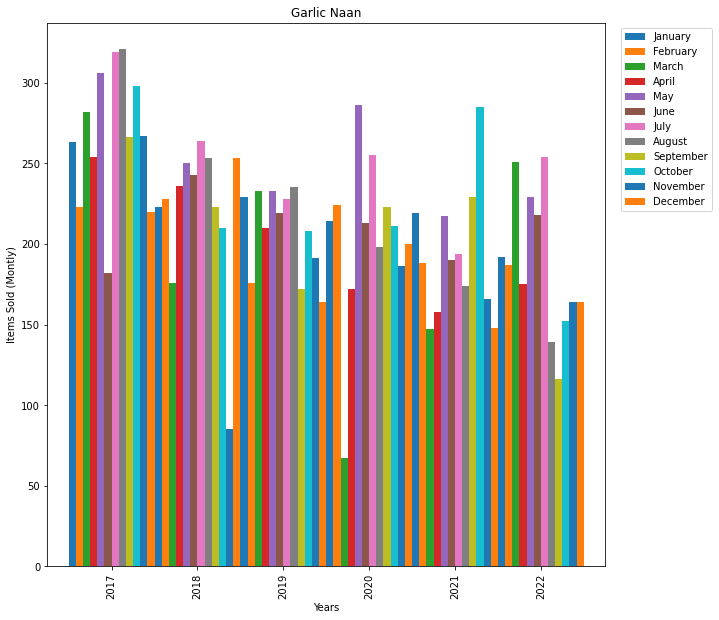

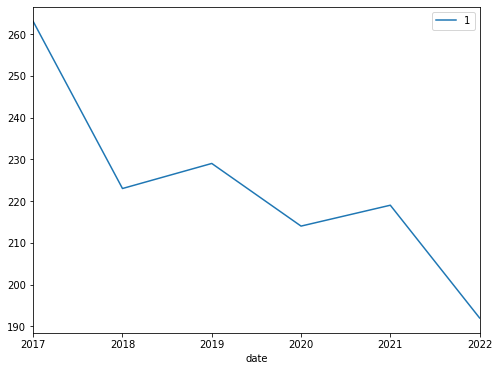

In [35]:
item_df = []
ignore_items = ['Paper Carry Bag','BYO Per Head','Reuserble Bag', 'Can drinks']
for i in range(1):
    item = total_sold_df.loc[i,'item']
    
    if item not in ignore_items:
        item_df = sql_item(item)
        item_df['Month'] = item_df['date'].dt.month
        item_df = item_df.drop_duplicates('date')
        
        interval = 3
        form = 'sold'
        
        #ml2_engine(item_df, item, form, interval)

        
        #ml_engine(item_df, item)
        py_bar(item_df,item)
        test_graph(t_1,item)
        #sea_scatter(item_df,item)
        
        #print(item_df.shape)
        #print(item_df.min())
        #print(f'Complete processing: {item}')
    

In [22]:
item_df.head()

,item,sold,date,total($),Month
0,Garlic Naan,263,2017-01-01,1099.25,1
1,Garlic Naan,223,2017-02-01,952.00,2
2,Garlic Naan,282,2017-03-01,1289.25,3
3,Garlic Naan,254,2017-04-01,1157.75,4
4,Garlic Naan,306,2017-05-01,1398.25,5


In [24]:
item_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72 entries, 0 to 72
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   item      72 non-null     object        
 1   sold      72 non-null     int64         
 2   date      72 non-null     datetime64[ns]
 3   total($)  72 non-null     float64       
 4   Month     72 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 3.4+ KB


In [31]:
item_df.sort_values(by=['Month', 'date']).head(10)

,item,sold,date,total($),Month
0,Garlic Naan,263,2017-01-01,1099.25,1
13,Garlic Naan,223,2018-01-01,1007.75,1
25,Garlic Naan,229,2019-01-01,1036.00,1
37,Garlic Naan,214,2020-01-01,978.25,1
49,Garlic Naan,219,2021-01-01,992.00,1
61,Garlic Naan,192,2022-01-01,872.25,1
1,Garlic Naan,223,2017-02-01,952.00,2
14,Garlic Naan,228,2018-02-01,1044.00,2
26,Garlic Naan,176,2019-02-01,804.00,2
38,Garlic Naan,224,2020-02-01,1033.25,2


In [64]:
meat_list = ['beef', 'chicken']
nomalisation = ['minmax', 'scaler', 'none']

7/7 [==============================] - 0s 1ms/step
Epoch 1/5
5/5 [==============================] - 1s 152ms/step - loss: 0.3488 - val_loss: 0.0839
Epoch 2/5
5/5 [==============================] - 0s 8ms/step - loss: 0.3292 - val_loss: 0.0714
Epoch 3/5
5/5 [==============================] - 0s 9ms/step - loss: 0.3087 - val_loss: 0.0600
Epoch 4/5
5/5 [==============================] - 0s 8ms/step - loss: 0.2869 - val_loss: 0.0514
Epoch 5/5
1/1 [==============================] - 0s 162ms/step
Epoch 1/5
6/6 [==============================] - 1s 43ms/step - loss: 0.4092 - val_loss: 0.0962
Epoch 2/5
6/6 [==============================] - 0s 7ms/step - loss: 0.3860 - val_loss: 0.0829
Epoch 3/5
6/6 [==============================] - 0s 6ms/step - loss: 0.3624 - val_loss: 0.0740
Epoch 4/5
6/6 [==============================] - 0s 6ms/step - loss: 0.3371 - val_loss: 0.0690
Epoch 5/5
7/7 [==============================] - 0s 1ms/step
Epoch 1/36
5/5 [==============================] - 3s 128ms/ste

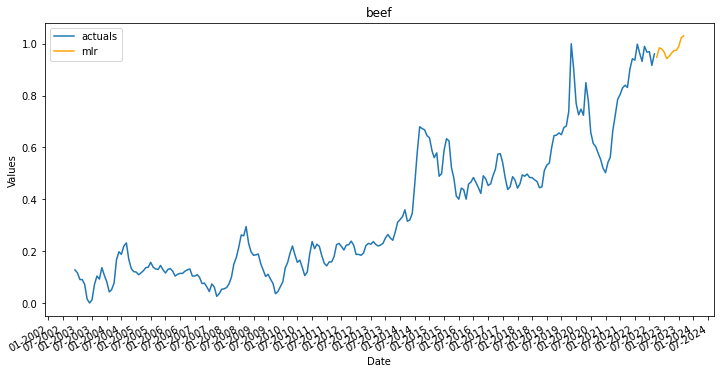

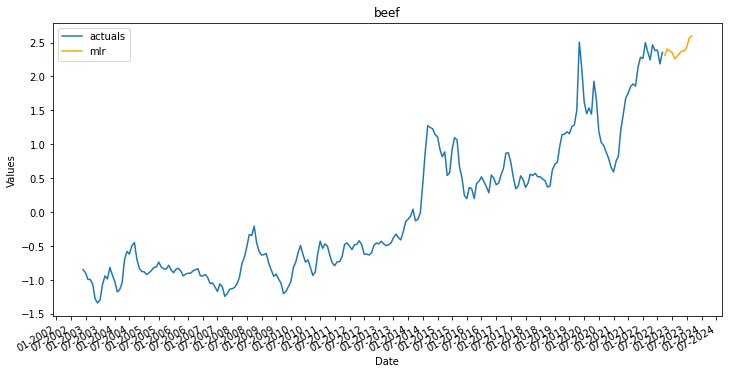

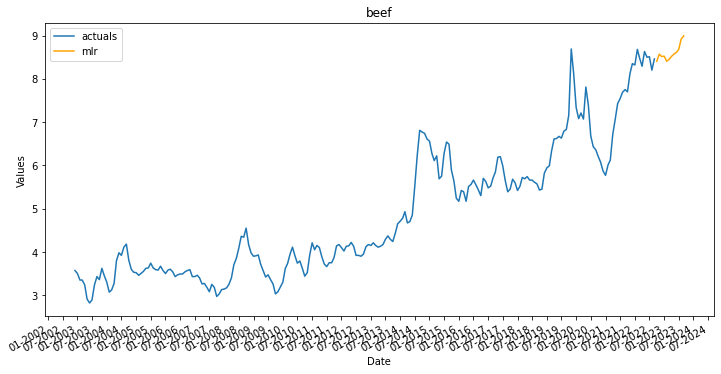

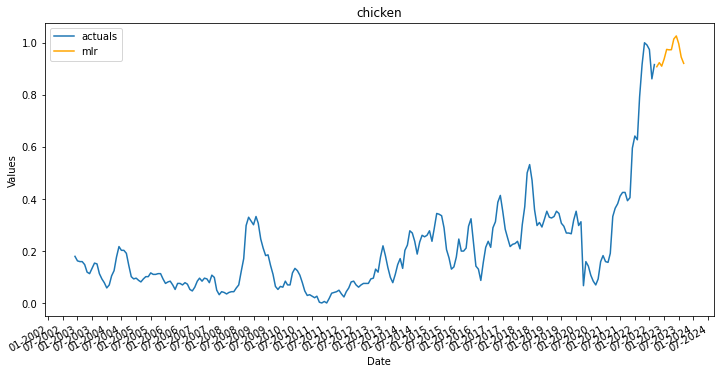

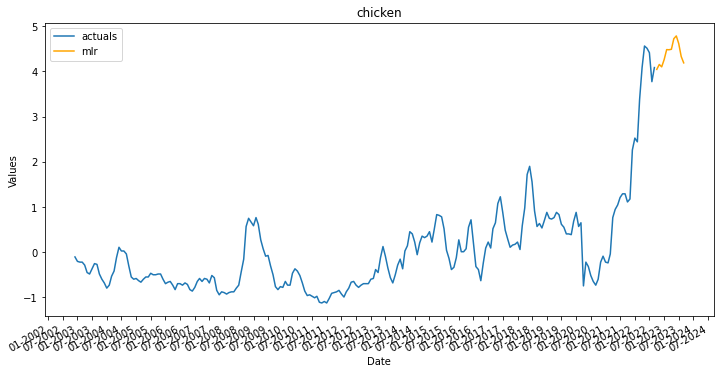

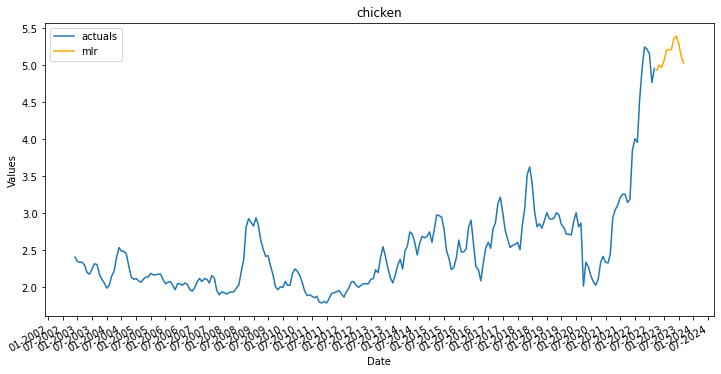

In [66]:
meat_df = pd.DataFrame()
for protein in meat_list:
    meat_df = sql_meat_item(protein)
    for style in nomalisation:
        if style == 'minmax':
            data = meat_df['price']
            values = data.values
            values = values.reshape((len(values), 1))
            scaler = MinMaxScaler(feature_range=(0, 1))
            scaler = scaler.fit(values)
            normalized = scaler.transform(values)
            normalized = pd.DataFrame(normalized)
            meat_df[style] = normalized
            ml2_engine(meat_df, protein, style,12)
        
        elif style == 'scaler':
            data = meat_df['price']
            values = data.values
            values = values.reshape((len(values), 1))
            scaler = StandardScaler()
            scaler = scaler.fit(values)
            normalized = scaler.transform(values)
            normalized = pd.DataFrame(normalized)
            meat_df[style] = normalized
            ml2_engine(meat_df, protein, style,12)
        
        elif style == 'none':
            none = 'price'
            ml2_engine(meat_df, protein, none, 12)